In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
covid_data = pd.read_csv("Covid Dataset.csv")
covid_data.shape

(5434, 21)

In [3]:
covid_data.dropna(inplace=True)
covid_data.shape

(5434, 21)

In [4]:
covid_data.describe()

,Breathing Problem,Fever,Dry Cough,Sore throat,Running Nose,Asthma,Chronic Lung Disease,Headache,Heart Disease,Diabetes,...,Fatigue,Gastrointestinal,Abroad travel,Contact with COVID Patient,Attended Large Gathering,Visited Public Exposed Places,Family working in Public Exposed Places,Wearing Masks,Sanitization from Market,COVID-19
count,5434,5434,5434,5434,5434,5434,5434,5434,5434,5434,...,5434,5434,5434,5434,5434,5434,5434,5434,5434,5434
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,1,1,2
top,Yes,Yes,Yes,Yes,Yes,No,No,Yes,No,No,...,Yes,No,No,Yes,No,Yes,No,No,No,Yes
freq,3620,4273,4307,3953,2952,2920,2869,2736,2911,2846,...,2821,2883,2983,2726,2924,2820,3172,5434,5434,4383


C:\Users\Amin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


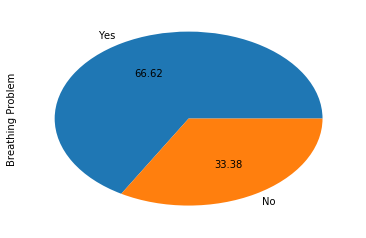

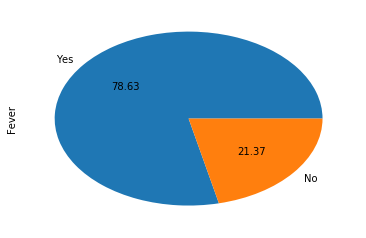

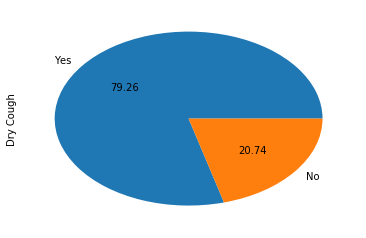

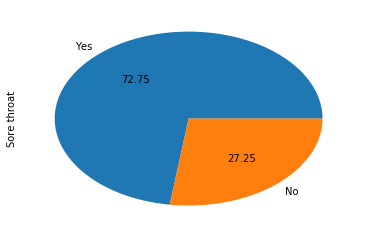

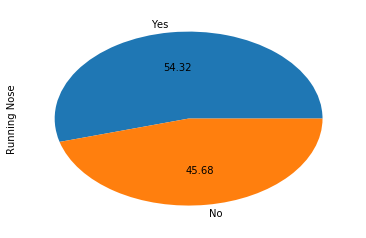

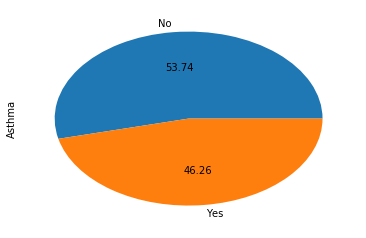

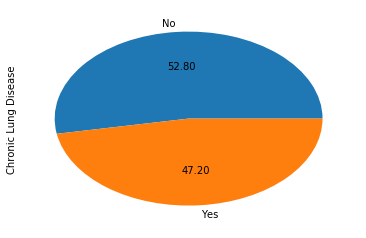

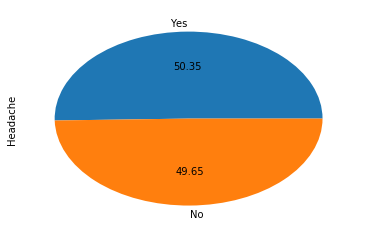

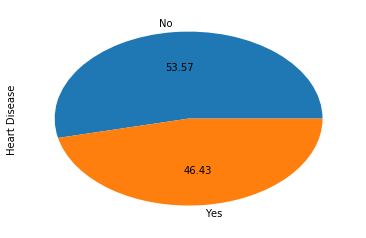

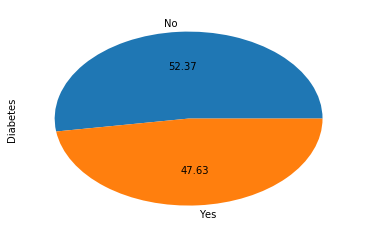

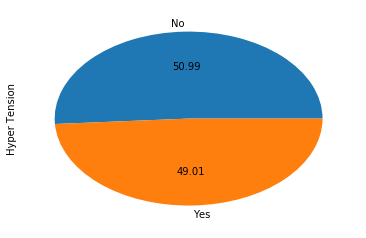

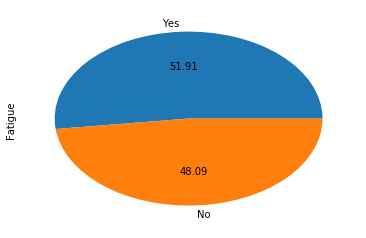

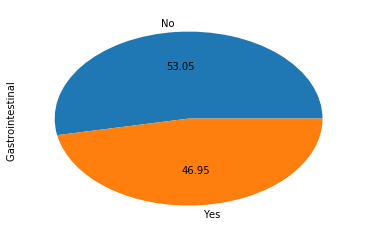

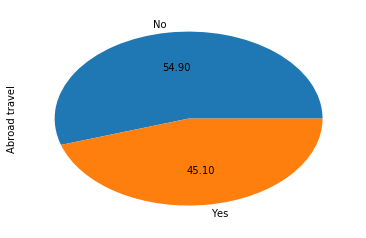

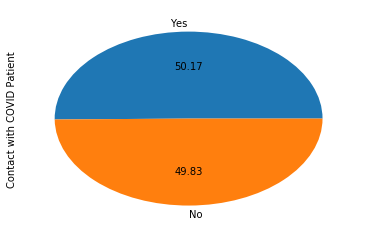

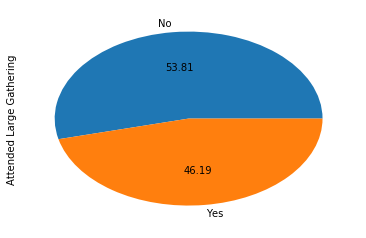

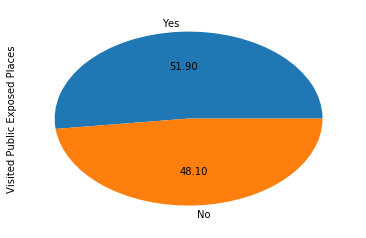

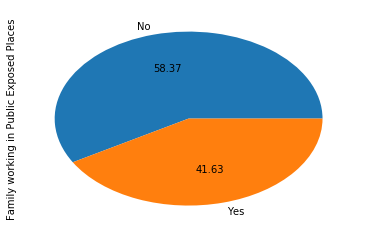

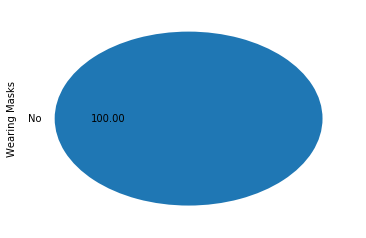

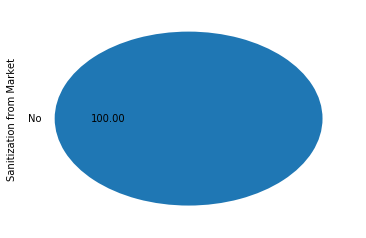

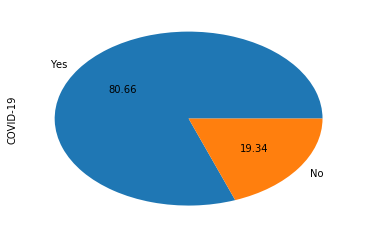

In [5]:
for col in covid_data.columns:
    plt.figure()
    covid_data[col].value_counts().plot(kind='pie',subplots=True, autopct='%.2f')

In [6]:
covid_data1 = covid_data.drop(['Wearing Masks','Sanitization from Market'],axis=1)
covid_data1.shape

(5434, 19)

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
covid_data2 = pd.DataFrame()
for col in covid_data1.columns:
    covid_data2[col] = le.fit_transform(covid_data1[col])
print('one hot encoded dataset shape',covid_data2.shape)
print(covid_data2['COVID-19'].value_counts())

one hot encoded dataset shape (5434, 19)
1    4383
0    1051
Name: COVID-19, dtype: int64


In [8]:
from sklearn.utils import resample

In [9]:

# Separate majority and minority classes
df_majority = covid_data2[covid_data2['COVID-19']==1]
df_minority = covid_data2[covid_data2['COVID-19']==0]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=4383,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled['COVID-19'].value_counts()

1    4383
0    4383
Name: COVID-19, dtype: int64

In [10]:
from sklearn.model_selection import train_test_split
test_size = 0.2
seed = 123
x_train, x_test, y_train, y_test = train_test_split(df_upsampled.drop(['COVID-19'],axis=1), df_upsampled['COVID-19'], test_size=test_size, random_state=seed)


In [11]:
x_train.head()

,Breathing Problem,Fever,Dry Cough,Sore throat,Running Nose,Asthma,Chronic Lung Disease,Headache,Heart Disease,Diabetes,Hyper Tension,Fatigue,Gastrointestinal,Abroad travel,Contact with COVID Patient,Attended Large Gathering,Visited Public Exposed Places,Family working in Public Exposed Places
938,1,1,1,1,1,1,0,1,1,1,0,0,1,1,1,0,1,0
4605,0,0,1,1,1,0,1,0,1,1,1,1,1,0,0,0,1,1
2121,0,1,1,1,0,0,0,1,0,1,0,0,1,1,0,0,1,1
1897,1,1,1,1,1,0,1,1,1,0,1,0,0,0,1,1,1,1
785,1,1,1,1,0,0,0,0,1,0,1,1,0,1,1,1,1,1


In [12]:
import torch
from torch import nn
from torch.nn import functional as F

class Net(nn.Module):
    def __init__(self,input_shape):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_shape,32)
        self.fc2 = nn.Linear(32,64)
        self.fc3 = nn.Linear(64,1)
    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [13]:
learning_rate = 0.01
epochs = 100
# Model , Optimizer, Loss
model = Net(input_shape = x_train.shape[1])
print(model)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()

Net(
  (fc1): Linear(in_features=18, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


In [14]:
#defining dataset class
from torch.utils.data import Dataset, DataLoader
class dataset(Dataset):
    
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.length = self.x.shape[0]
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
    def __len__(self):
        return self.length
    
trainset = dataset(x_train.values,y_train.values)
testset = dataset(x_test.values,y_test.values)
#DataLoader
trainloader = DataLoader(trainset,batch_size=64,shuffle=False)

In [15]:
from sklearn.metrics import accuracy_score
losses = []
accur = []
for i in range(50):
    for j,(x_trai,y_trai) in enumerate(trainloader):

        #calculate output
        output = model(x_trai)

        #calculate loss
        loss = loss_fn(output,y_trai.reshape(-1,1))

        #accuracy
        predicted = model(torch.tensor(trainset.x,dtype=torch.float32))
        predicted = predicted.reshape(-1).detach().numpy()
        predictions = ((predicted) > 0.5).astype("int32")
        acc = accuracy_score(trainset.y,predictions)
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if i%10 == 0:
        losses.append(loss)
        accur.append(acc)
        print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))


C:\Users\Amin\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


epoch 0	loss : 0.25915467739105225	 accuracy : 0.9723331431831147
epoch 10	loss : 0.1649676263332367	 accuracy : 0.9895892755276668
epoch 20	loss : 0.14767032861709595	 accuracy : 0.9895892755276668
epoch 30	loss : 0.14867524802684784	 accuracy : 0.9895892755276668
epoch 40	loss : 0.1310197114944458	 accuracy : 0.9895892755276668


In [16]:
pred = model(testset.x)
pred1 = pred.reshape(-1).detach().numpy()
pred2 = ((pred1) > 0.5).astype("int32")

In [17]:
acc1 = accuracy_score(testset.y,pred2)

In [18]:
acc1

0.9823261117445838

In [19]:
trainset.y

tensor([1., 0., 1.,  ..., 0., 1., 1.])

In [20]:
from sklearn.ensemble import GradientBoostingRegressor

C:\Users\Amin\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [21]:
GBR = GradientBoostingRegressor(n_estimators=100, max_depth=4)

In [22]:
GBR.fit(x_train, y_train)
acc_gbk=GBR.score(x_test, y_test)*100
acc_gbk

90.93754832509205